In [1]:
from typing import Sequence, Callable
from collections import defaultdict
import operator
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [2]:
v = pd.read_csv('data/functions_encoded.csv')
labels = pd.read_csv('./data/labels_encoded.csv')

In [3]:
def mysample(v, sample_size):
    r = random.sample(list(v.apn.unique()), k=sample_size)
    #apns = v.apn.unique sample(sample_size, random_state=42)
    return v[v.apn.isin(r)][['apn', 'nf']]

In [4]:
smp = mysample(v, 100)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)

In [5]:
funcs = v.groupby(by='apn')['nf'].apply(set)


def adf(apid1: int, apid2: int,funcs ) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]
    
    a= len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

In [6]:
def create_net(gamma:float, apns: Sequence[int], distance=lambda x, y: adf(x, y, funcs_smp)) -> Sequence[int]:   
    np.random.shuffle(apns)
    net = []

    for a in apns:
        insert = True
        for n in net: 
            if distance(a, n) <= gamma:
                insert = False
                break
        if insert:
            net.append(a)
            
    return net

def calculate_distances(net, distance: Callable)->Sequence[float]:
    distances = []
    for o in net:
        for z in net:
            if o == z:
                continue
            distances.append(distance(o, z))
    return distances



def create_aggregating_net(gamma:float, apns: Sequence[int], distance=lambda x, y: adf(x, y, funcs_smp)):   
  #  np.random.shuffle(apns)
    net = defaultdict(list)

    for a in apns:
        insert = True
        for n in net.keys(): 
            if distance(a, n) <= gamma:
                insert = False
                net[n].append(a)
                break #does it always belong to only one point? probably
        if insert:
            net[a] = list()
            
    return net

def app_k_nearest(k, apps, new_app, distance):
    byd = sorted(apps, key=lambda lp: distance(lp, new_app))
    return byd[:k]

def find_closest(net, app, distance, k=1):
    anchors = app_k_nearest(k=k, apps=net.keys(), new_app=app, distance=distance)
    new_list = []
    for a in anchors:
        if len(net[a])> 0:
            new_list+=net[a]
        new_list.append(a)       
    ns=app_k_nearest(k=1, apps=new_list, new_app=app, distance=distance)[0]
        
    return ns

## Marging methods

In [7]:
# takes keys from both networks if key overlap the aggregates are merged
def naive_merge(n1, n2):
    nx = {**n1, **n2}
    for key in nx.keys():
        if key in n1:
            nx[key] = list(set(nx[key]+n1[key]))
    return nx

# takes only keys that are at least gamma from each other, for keys closer than gamma, their aggregats are merged
def key_based_merg(n1, n2, distance, gamma):
    nx = {**n1}
    for k, l in n2.items():
        idf = True
        for k2 in nx.keys():
            if distance(k, k2)<gamma:
                nx[k2]+=[li for li in l]
                idf = False
                break
       
        if idf:
            if k not in nx:
                nx[k]=[]
            nx[k]+=[li for li in l]
    
    return nx

#calculates net over point nets and use it as keys of the merged network (similar/same? to the key-based)
def net_based_merge(n1, n2, distance, gamma):
    nn = create_aggregating_net(gamma=gamma, 
                                apns=list(n1.keys())+list(n2.keys()), 
                                distance=distance)
    targ = defaultdict(list)

    for k,v in nn.items():
        targ[k] = n1.get(k, []).copy()
        targ[k] +=n2.get(k, []).copy()
        for el in v:
            targ[k] +=n1.get(el, []).copy()
            targ[k] +=n2.get(el, []).copy()
            targ[k].append(el)
    
    return targ

def net_based_multi_merge(nets, distance, gamma):
    apns = []
    for net in nets:
        apns+=list(net.keys())
        
    nn = create_aggregating_net(gamma=gamma, 
                                apns=apns, 
                                distance=distance)
    targ = defaultdict(list)

    for k,v in nn.items():
        for net in nets:
            targ[k] += net.get(k, []).copy()
            
        for el in v:
            for net in nets:
                targ[k] +=net.get(el, []).copy()
            targ[k].append(el)
    
    return targ

## Merge Quality Measurements

In [8]:
#checks if pairweise key distances are >= gamma (should be the case)
def are_keys_correct(net, distance, gamma):
    isok = True
    keylist = list(net.keys())
    for i,k in enumerate(keylist):
        for j in keylist[i+1:]:
            if (d:=distance(k, j)) < gamma:
                #isok=False
                return False
                
    return True

# checks if distance between key and points it aggregates are < gamma (should be the case)
def are_distances_correct(net, gamma, distance):
    for k, l in net.items():
        m = [distance(le, k) for le in l if distance(le, k) > gamma]
        if len(m)> 0:
            return False
    return True

def get_elements(net):
    all_elements = []
    for k, v in net.items():
        l = [vi for vi in v]
        all_elements = all_elements+l
        all_elements.append(k)
    return all_elements

## Examples

In [238]:
distance = lambda x,y: adf(x,y, funcs_smp)

In [239]:
n_merged = naive_merge(n1, n2)

In [240]:
# distances between keys might be to small
# distances within key will be ok (as they stam from a correct network)
are_keys_correct(n_merged, distance=distance, gamma=30), are_distances_correct(n_merged, distance=distance, gamma=30)

(False, True)

In [241]:
k_merged = key_based_merg(n1, n2, distance, 30)

In [242]:
# keys will be in proper distances
# withing one key they might be some aggregates that are too far
are_keys_correct(k_merged, distance=distance, gamma=30), are_distances_correct(k_merged, distance=distance, gamma=30)

(True, True)

In [243]:
net_merged = net_based_merge(n1, n2, distance, 30)

In [244]:
# keys will be correct (they form a correct network)
# agrregates might not be correct
are_keys_correct(net_merged, distance=distance, gamma=30), are_distances_correct(net_merged, distance=distance, gamma=30)

(True, True)

## Loop

In [9]:
from tqdm.notebook import tqdm

In [246]:
def get_stats(net, distance, gamma):
    kc = are_keys_correct(net, distance=distance, gamma=gamma)
    dc = are_distances_correct(net, distance=distance, gamma=gamma)
    kl = len(net.keys())
    
    return {'kc': kc, 'dc': dc, 'kl':kl, 'gamma': gamma}

In [247]:
naive_stats = list()
k_stats = list()
net_stats = list()
o_stats = list()

gamma = 30
distance = lambda x,y: adf(x,y, funcs_smp)

for run in tqdm(range(100)):
    gamma = random.randint(0, 90)
    a1, a2 = train_test_split(smp.apn.unique(), test_size=.5)

    n1 = create_aggregating_net(gamma=gamma, apns=a1, distance=lambda x,y: adf(x,y, funcs_smp) )
    n2 = create_aggregating_net(gamma=gamma, apns=a2, distance=lambda x,y: adf(x,y, funcs_smp) )

    n_merged = naive_merge(n1, n2)
    naive_stats.append(get_stats(n_merged, distance=distance, gamma=gamma))
    
    #k_merged = key_based_merg(n1, n2, distance, gamma)
    #k_stats.append(get_stats(k_merged, distance=distance, gamma=gamma))
    
    net_merged = net_based_merge(n1, n2, distance, gamma)
    net_stats.append(get_stats(net_merged, distance=distance, gamma=gamma))
    
    op = create_aggregating_net(gamma=gamma, apns=smp.apn.unique(), distance=distance)
    o_stats.append(get_stats(op, distance=distance, gamma=gamma))
    
    

In [8]:
def print_distance_stats(s, distance):
    dst = calculate_distances(s, distance)
    print(f"{min(dst)=} {max(dst)=} {np.mean(dst)=} {np.median(dst)=}")

In [54]:
print_distance_stats(smp.apn.unique(), distance=distance)

min(dst)=0.0 max(dst)=190.66462702871763 np.mean(dst)=73.68856945511949 np.median(dst)=74.16872656315464


In [248]:
netpd = pd.DataFrame(net_stats)
npd = pd.DataFrame(naive_stats)
opd = pd.DataFrame(o_stats)

In [249]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

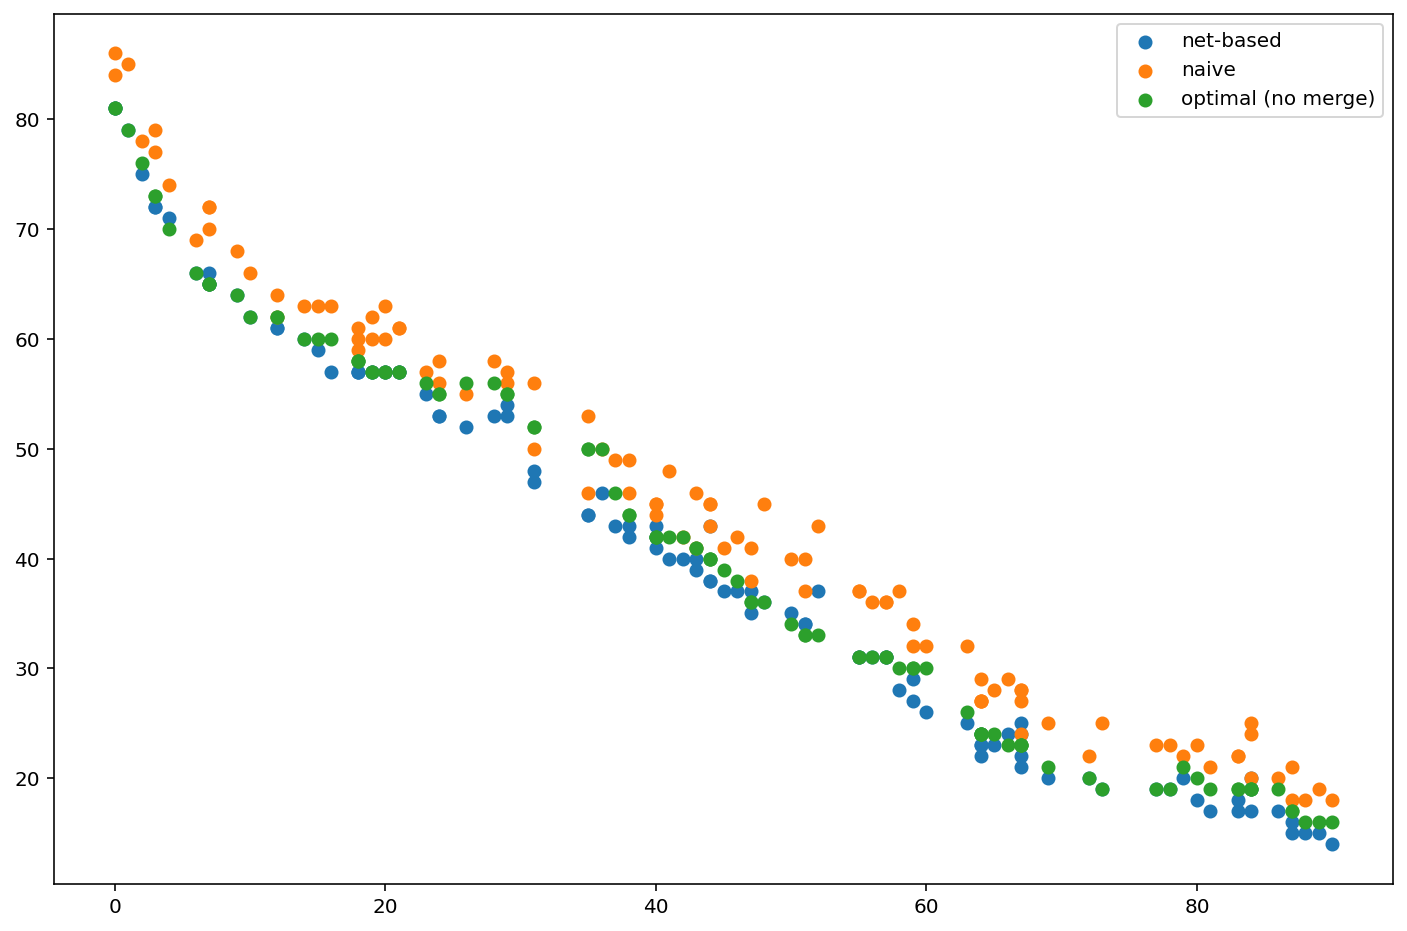

In [250]:
plt.figure(figsize=(12, 8))
plt.scatter(netpd.gamma, netpd.kl, label='net-based')
plt.scatter(npd.gamma, npd.kl, label='naive')
plt.scatter(opd.gamma, opd.kl, label='optimal (no merge)')
plt.legend()

## KNN with merged

## Influece of parameter k (how many anchors from point network should be considerd)

For naive merge there is some error for $k=1$ other than that always a point a 0.0 is found.

In [284]:
smp = mysample(v, 200)

In [293]:
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)
distance = lambda x,y: adf(x,y, funcs_smp)

In [294]:
gamma = 20
a1, a2 = train_test_split(smp.apn.unique(), test_size=.5)

n1 = create_aggregating_net(gamma=gamma, apns=a1, distance=lambda x,y: adf(x,y, funcs_smp) )
n2 = create_aggregating_net(gamma=gamma, apns=a2, distance=lambda x,y: adf(x,y, funcs_smp) )
n3 = create_aggregating_net(gamma=gamma, apns=smp.apn.unique(), distance=distance)

In [295]:
net_merged = net_based_merge(n1, n2, distance, gamma)
naive_merged = naive_merge(n1, n2)

In [296]:
apps = random.sample(list(smp.apn.unique()), k=80)

In [297]:
for k in range(1, 5):
    d2, d3 = [], []
    for app in apps:
        ns2 = find_closest(naive_merged, app, distance, k=k)
        ns3 = find_closest(net_merged, app, distance, k=k)
        ds2, ds3 = distance(ns2, app), distance(ns3, app)
        #if (ds1+ds2+ds3>0):
        #    print(ds1, ds2, ds3)
        d2.append(ds2)
        d3.append(ds3)
    for distances in [d2, d3]:    
        print(f"{k=}  {np.min(distances)} {np.mean(distances)} {np.max(distances)}")
    

k=1  0.0 0.191062633671423 7.874007874011811
k=1  0.0 0.0 0.0
k=2  0.0 0.0 0.0
k=2  0.0 0.0 0.0
k=3  0.0 0.0 0.0
k=3  0.0 0.0 0.0
k=4  0.0 0.0 0.0
k=4  0.0 0.0 0.0


## Voting networks

In [9]:
def classify_app(appid, labels):
    return labels[labels.apn==appid]['malware_label'].values[0]


In [10]:
labels = pd.read_csv('data/labels_encoded.csv')

In [11]:
def votes_from_list(li, labels):
    classes = [int(classify_app(a, labels)) for a in li]
    su = sum(classes)
    return len(classes)-su, su

def convert_to_voting(net, labels):
    voting_network = defaultdict(lambda: [0, 0])

    for k, l in net.items():
        bi, mal = votes_from_list(l+[k], labels)
        voting_network[k]=[bi, mal]
        
    return voting_network

In [12]:
def merge_voting_nets(nets, distance, gamma, labels):
    print("This has to be tested")
    apns = []
    for net in nets:
        apns+=list(net.keys())
        
    nn = create_aggregating_net(gamma=gamma, 
                                apns=apns, 
                                distance=distance)
    targ = defaultdict(lambda: [0, 0])

    for k,v in nn.items():
        for net in nets:
            targ[k] = [i+j for i,j in zip(targ[k], net.get(k, [0, 0]))]
            
        for el in v:
            for net in nets:
                targ[k] = [i+j for i,j in zip(targ[k], net.get(el, [0, 0]))]
            targ[k] = [i+j for i,j in zip(targ[k], convert_to_voting([el], labels))]
    
    return targ

In [27]:
fn = create_aggregating_net(gamma=gamma, apns=smp.apn.unique(), distance=lambda x,y: adf(x,y, funcs_smp) )
fn0 = create_aggregating_net(gamma=0, apns=smp.apn.unique(), distance=lambda x,y: adf(x,y, funcs_smp) )

vfn = convert_to_voting(fn, labels)
vfn0 = convert_to_voting(fn0, labels)

In [28]:
allapns = smp.apn.unique()
aps = np.random.choice(allapns, size=90)

In [29]:
results = {}

for ap in aps:
    netknn = app_k_nearest(k=1, apps=vfn.keys(), new_app=ap, distance=distance)[0]
    fullknn = app_k_nearest(k=1, apps=allapns, new_app=ap, distance=distance)[0]
    net0knn = app_k_nearest(k=1, apps=vfn0.keys(), new_app=ap, distance=distance)[0]
    
    votes = vfn[netknn]
    votes0 = vfn0[net0knn]
    results[ap] = {
        'true_value': int(classify_app(ap, labels)),
        'majority_vote': int(votes0[0]< votes0[1]),
        'net_vote': int(votes[0]<votes[1]),
        'knn1_value': int(classify_app(fullknn, labels)),
        'net_node': netknn,
        'net0_node': net0knn
    }
    

In [30]:
rs = pd.DataFrame.from_dict(results, orient='index')

In [31]:
# misses:
rs[rs.majority_vote!=rs.net_vote]

,true_value,majority_vote,net_vote,knn1_value,net_node,net0_node
4145,0,0,1,0,24167,19026
18153,0,0,1,0,24167,19706
19026,0,0,1,0,24167,19026
18145,0,0,1,0,24167,18145
4788,0,0,1,0,24167,19026
19706,0,0,1,0,24167,19706


In [32]:
vfn[13716], vfn0[13716], gamma

([0, 0], [0, 0], 20)

## Large experiment

1. distribute the data on "workers"
2. create network of increasing gammas (0, 1, 2, 4, 8,...)
3. merge (from smalles gamma upwards?)
4. use knn to evaluate the quality of the network

In [13]:
def partition_data(data: Sequence[int], partitions: int) -> Sequence[Sequence[int]]:
    np.random.shuffle(data)
    part_len = int(len(data)/partitions)
    if part_len < 1:
        print("Partition number to high")
        return []
        
    return [data[i:i+part_len] for i in range(0, len(data), part_len)]
        

In [11]:
smp = mysample(v, 1000)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)
pots = v[~v.apn.isin(smp.apn.unique())]
distance=lambda x,y: adf(x,y, funcs_smp) 

#### Stats:

| stat | value|
| - | - |
|max dist| 247|
|min dist|   0|
|median dist| 62|


In [106]:
data = smp.apn.unique()
distance=lambda x,y: adf(x,y, funcs_smp) 
partitions = partition_data(data, 128)
ntw = defaultdict(list)
g = 0

while len(partitions)>0:
    print(f"Number of partitions: {len(partitions)}. Calculating network with gamma={g}")
    networks = [create_aggregating_net(gamma=g, apns=part, distance=distance) for part in partitions]
    ntw[g] = networks
    merged = [net_based_multi_merge(nets, distance, g) for nets in zip(networks[::2], networks[1::2])]
    if (len(networks)>1) and (len(networks) %2==1):
        merged.append(networks[-1])
        
    partitions = [get_elements(a) for a in merged]
    if g ==0:
        g+=1
    else:
        g*=2

Number of partitions: 143. Calculating network with gamma=0
Number of partitions: 72. Calculating network with gamma=1
Number of partitions: 36. Calculating network with gamma=2
Number of partitions: 18. Calculating network with gamma=4
Number of partitions: 9. Calculating network with gamma=8
Number of partitions: 5. Calculating network with gamma=16
Number of partitions: 3. Calculating network with gamma=32
Number of partitions: 2. Calculating network with gamma=64
Number of partitions: 1. Calculating network with gamma=128


In [13]:
funcs = v.groupby(by='apn')['nf'].apply(set)

In [15]:
reference_network = create_aggregating_net(gamma=128, apns=v.apn.unique(), distance=lambda x,y: adf(x,y, funcs))

In [14]:
def compare_nets(new_apps, net1, net2, distance):
    mi1 = list()
    mi2 = list()
    
    for new_app in new_apps:
        ck = find_closest(net1, new_app, distance, k=1)
        d1= distance(ck, new_app)

        cl = find_closest(net2, new_app, distance, k=1)
        d2 = distance(cl, new_app)
        
        
        if d1!=d2:
            mi1.append(d1)
            mi2.append(d2)

            
            #print(f"{new_app} {ck}!={cl} {d1} {d2}")
         #   if d1>d2:
          #      mi1+=[(new_app, ck)]
          #  else:
          #      mi2+=[(new_app, cl)]
                
    return mi1, mi2

In [20]:
partitions = partition_data(v.apn.unique(), 8)
nets = [create_aggregating_net(gamma=128, apns=part, distance=lambda x,y: adf(x,y, funcs)) for part in partitions]
mer_res = net_based_multi_merge(nets, distance=lambda x,y: adf(x,y, funcs), gamma=128) 

In [32]:
new_apps = random.sample( list(smp.apn.unique()), k=5)

In [42]:
ref_missed, mer_missed = compare_nets(new_apps, reference_network, mer_res, distance=lambda x,y: adf(x,y, funcs))

In [45]:
print(f"Ref network missed: {len(ref_missed)} vs. {len(mer_missed)} by merged network")

for d in ref_missed:
    print(d, adf(d[0], d[1], funcs))

for d in mer_missed:
    print(d, adf(d[0], d[1], funcs))

### Setup once more
for different gammas =0, 1, 2, 4, 8, 16 create network in two ways: 
- centralized (all data)
- distributed (constant number of partitions?)
- possibly distributed with herarchical merging
- compare their performance with a withhold dataset

In [15]:
from tqdm.notebook import tqdm

In [16]:
def one_shot_merge(parts, distance, gamma):
    networks = [create_aggregating_net(gamma=gamma, apns=part, distance=distance) for part in parts]
    merged = net_based_multi_merge(networks, distance, gamma)
    return merged

In [17]:
n_parts = 10
sample_size = 1000
withhold_size = 500

In [18]:
smp = mysample(v, sample_size)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)

In [19]:
data = smp.apn.unique()

In [20]:
not_data = v[~v.apn.isin(data)]

In [21]:
withhold_data = random.sample(list(not_data.apn.unique()), withhold_size)

In [22]:
distance=lambda x,y: adf(x,y, funcs_smp) 
partitions = partition_data(data, n_parts)

In [23]:
res = dict()
nets = dict()

for gamma in tqdm([0, 1, 2, 4, 8, 16]):
    os_merged = one_shot_merge(parts=partitions, distance=distance, gamma=gamma)
    ref_network = create_aggregating_net(gamma=gamma, apns=data, distance=distance)
    mi1, mi2 = compare_nets(withhold_data, os_merged, ref_network, distance=lambda x,y: adf(x, y, funcs))
    res[gamma] = [mi1.copy(), mi2.copy()]
    nets[gamma] = [os_merged.copy(), ref_network.copy()]

In [59]:
#df = pd.DataFrame.from_dict(res, orient='index')
#df.to_csv('data/distances-merg-5000.csv')

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

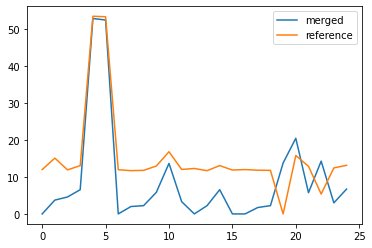

In [111]:
plt.plot(m1, label='merged')
plt.plot(m2, label='reference')
plt.legend()

In [24]:
keys = [(len(a.keys()), len(b.keys()) ) for gamma,(a,b) in nets.items()]

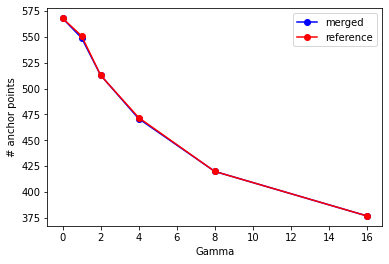

In [46]:
a, b = list(zip(*keys))
gammas = [0, 1, 2, 4, 8, 16]
plt.plot(gammas, a, 'bo-', label='merged')
plt.plot(gammas, b, 'ro-', label='reference')
plt.legend();
plt.xlabel('Gamma')
plt.ylabel('# anchor points');

Text(0.5, 1.0, 'Gamma = 0')

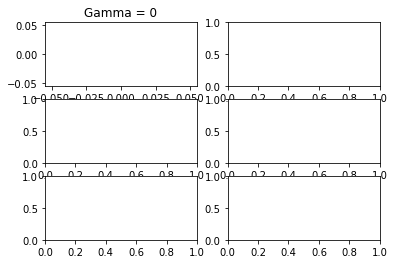

In [48]:
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(res[0][0], label='merged')
axs[0, 0].plot(res[0][1], label='reference')
axs[0, 0].set_title('Gamma = 0')

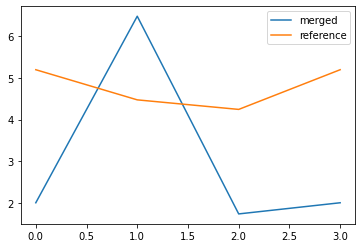

In [53]:
plt.plot(res[8][0], label='merged')
plt.plot(res[8][1], label='reference')
plt.legend()

In [51]:
for gamma, (r1, r2) in res.items():
    print(gamma, len(r1), len(r2))

0 0 0
1 0 0
2 0 0
4 0 0
8 4 4
16 0 0
